In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path

# Comment here to add in for either mac or linux computer
if os.environ['SHELL'] == '/bin/bash':   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
else:    # For mac laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.plotting.spikes import plot_raster
from neuropy.plotting.signals import plot_signal_w_epochs
from neuropy.plotting.spikes import plot_binned_raster

In [2]:
# Define a class for a typical recording or set of recordings
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more than one .xml file"
        
        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        eegfiles = sorted(basepath.glob('*.eeg'))
        assert len(eegfiles) == 1, "Fewer/more than one .eeg file detected"
        self.eegfile = BinarysignalIO(eegfiles[0], n_channels=self.recinfo.n_channels,
                                     sampling_rate=self.recinfo.eeg_sampling_rate,
                                     )
        try:
            self.datfile = BinarysignalIO(eegfiles[0].with_suffix('.dat'),
                                         n_channels=self.recinfo.n_channels,
                                         sampling_rate=self.recinfo.dat_sampling_rate,
                                         )
        except FileNotFoundError:
            print('No dat file found, not loading')
                
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
sess_dir = '/data2/Trace_FC/Recording_Rats/Han/2022_08_04_recall1/'
sess_name = f"{sess_dir.split('/')[-3]}_{sess_dir.split('/')[-2].split('_')[-1]}"
sess = sess_use(sess_dir)
print(sess.recinfo)

filename: /data2/Trace_FC/Recording_Rats/Han/2022_08_04_recall1/Han_recall1.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 3594.69 seconds 
duration: 1.00 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.1  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)
art_epochs

Existing artifact epochs file loaded


11 epochs
Snippet: 
       start      stop label
0  381.0232  381.2760      
1  561.4368  561.6952      
2  661.1000  661.3360      
3  734.1248  734.3784      
4  942.7544  942.9848      

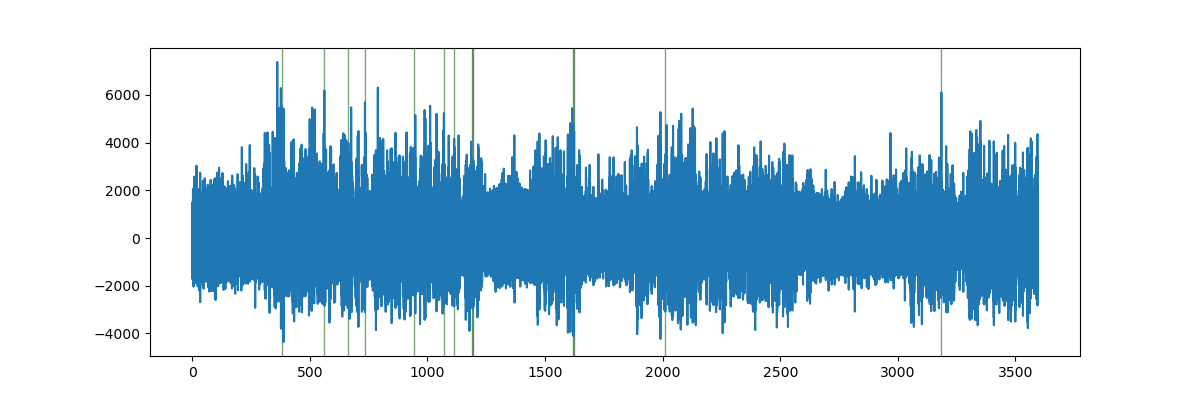

In [6]:
%matplotlib widget
_, ax = plt.subplots(figsize=(12, 4))
chan_plot = 6
ax.plot(signal.time, signal.traces[chan_plot])

for start, stop in zip(art_epochs.starts, art_epochs.stops):
    ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])


## Define probe group

/data2/Trace_FC/Recording_Rats/Han/2022_08_04_recall1/Han_recall1.probegroup.npy saved


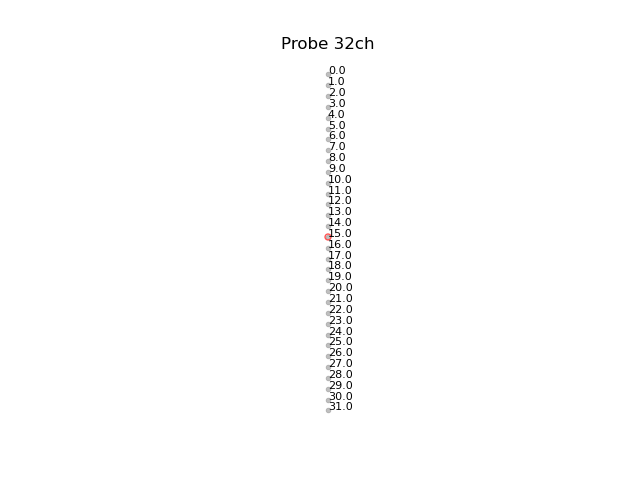

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=32, xpitch=0,
                   ypitch=50, channel_id=np.arange(31, -1, -1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=0.25
maxdur=20
thresh = (0.5, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 6

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [6]
993 epochs remaining with durations within (0.25,20)


## Detect SWR Epochs

In [38]:
from neuropy.analyses.oscillations import detect_ripple_epochs
ripple_channel = 6
thresh = (3, None)  # conservative but good
ripple_epochs = detect_ripple_epochs(signal, prbgrp, thresh=thresh, ripple_channel=ripple_channel, 
                                     ignore_epochs=art_epochs)


Selected channels for ripples: [6]
1015 epochs remaining with durations within (0.05,0.45)


## Start Wavelet Analysis

### Start with Theta

In [33]:
from neuropy.utils.signal_process import WaveletSg
theta_range = np.arange(4, 14, 0.25)  # How do I select these?
theta_channel = 6
wv_sig = WaveletSg(signal.time_slice(channel_id=theta_channel), freqs=theta_range, sigma=None)

interactive(children=(FloatSlider(value=20.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(…

<Axes: xlabel='Time', ylabel='Frequency'>

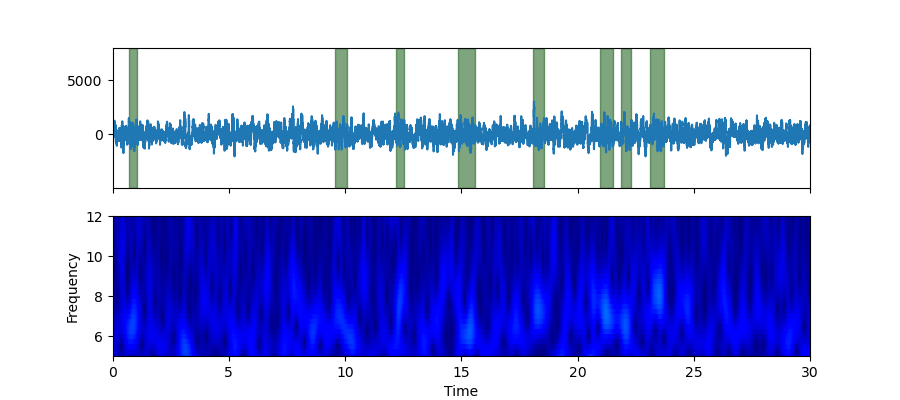

In [35]:
from neuropy.plotting.signals import plot_spectrogram, plot_spectrogram2
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))

plot_signal_w_epochs(signal, theta_channel, theta_epochs, ax=ax[0])

# plot_spectrogram(wv_sig.traces, time=[0, 1250*30], freq=[0, 10], freq_lim=[0, 10], ax=ax[1])
plot_spectrogram2(wv_sig, time=[0, 30], freq=[5, 12], freq_lim=[0, 10], ax=ax[1])

In [58]:
# Sanity check - run wavelet on signal from 0.5 seconds before to 1.5 seconds after the 
# start of each theta epoch
event_times = theta_epochs.starts
channel_use = 6
freq_range = np.arange(4, 12, 0.25)
buffer_sec = (0.25, 0.75)

sxx_list = []
for t_event in event_times:
    start_time = t_event - buffer_sec[0]
    stop_time = t_event + buffer_sec[1]
    wvlet_temp = WaveletSg(signal.time_slice(channel_id=channel_use, t_start=start_time, t_stop=stop_time), 
                           freqs=freq_range, sigma=None)
    sxx_list.append(wvlet_temp.traces)
# theta_epochs.starts[0]


interactive(children=(FloatSlider(value=20.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(…

<Axes: xlabel='Time', ylabel='Frequency'>

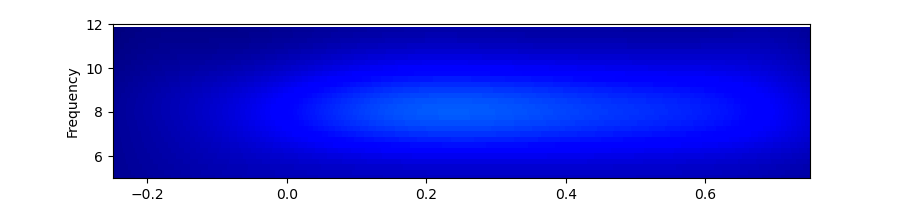

In [66]:
from neuropy.utils.signal_process import Spectrogram

sxx_mean = np.stack(sxx_list, axis=2).mean(axis=2)
wv_theta_mean = Spectrogram(sxx_mean, theta_range, sampling_rate=signal.sampling_rate, 
                            t_start=-buffer_sec[0])

_, ax = plt.subplots(figsize=(9, 2))
plot_spectrogram2(wv_theta_mean, time=[-buffer_sec[0], buffer_sec[1]], freq=[5, 12], 
                  ax=ax)

In [67]:
ripple_epochs

1015 epochs
Snippet: 
     start    stop  peak_time  peak_power label
0  3.0568  3.1696     3.1112    6.467839      
1  4.8144  4.9344     4.8624    8.994634      
2  5.1352  5.2192     5.1736    7.823237      
3  6.6152  6.7560     6.7216    9.370313      
4  7.7024  7.7968     7.7648    7.496606      

<Axes: >

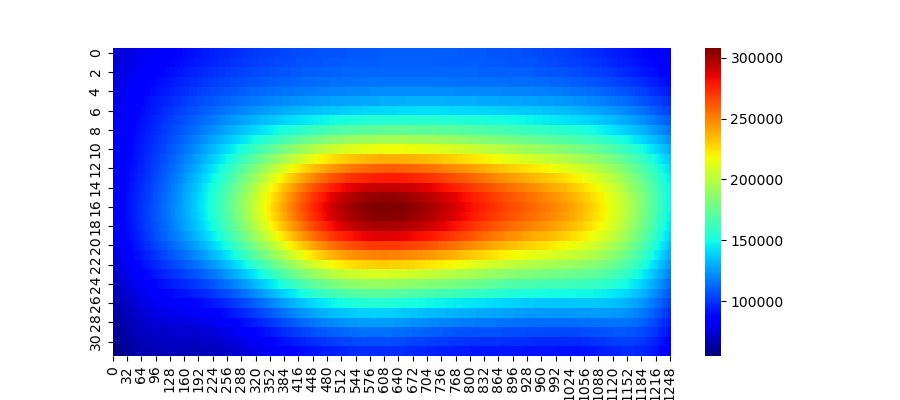

In [64]:
_, ax = plt.subplots(figsize=(9, 4))
sns.heatmap(sxx_mean, cmap='jet')


### Try out SWRs

In [37]:
swr_range = np.arange(125, 275, 5)
wv_sig_swr = WaveletSg(signal.time_slice(channel_id=theta_channel), freqs=swr_range, sigma=None)

interactive(children=(FloatSlider(value=20.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(…

<Axes: xlabel='Time', ylabel='Frequency'>

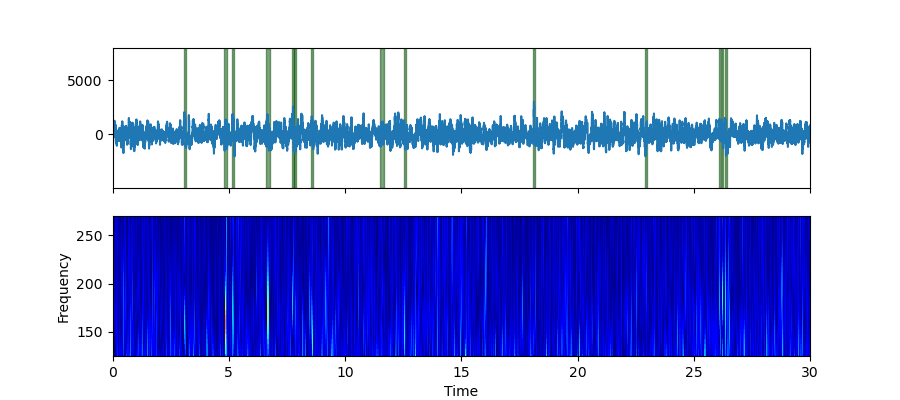

In [39]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(9, 4))

plot_signal_w_epochs(signal, theta_channel, ripple_epochs, ax=ax[0])

# plot_spectrogram(wv_sig.traces, time=[0, 1250*30], freq=[0, 10], freq_lim=[0, 10], ax=ax[1])
plot_spectrogram2(wv_sig_swr, time=[0, 30], freq=[125, 270], ax=ax[1])

In [ ]:
_, ax = plt.subplots(figsize=(12, 4))

sns.heatmap(wv_sig.traces, ax=ax, cmap='viridis')

In [69]:
start_time

2.8068

In [72]:
sxx2_mean.shape

(32, 1250)

In [81]:
ripple_epochs.to_dataframe()[

,start,stop,peak_time,peak_power,label,duration
0,3.0568,3.1696,3.1112,6.467839,,0.1128
1,4.8144,4.9344,4.8624,8.994634,,0.1200
2,5.1352,5.2192,5.1736,7.823237,,0.0840
3,6.6152,6.7560,6.7216,9.370313,,0.1408
4,7.7024,7.7968,7.7648,7.496606,,0.0944
...,...,...,...,...,...,...
1010,3587.5904,3587.6672,3587.6328,11.434342,,0.0768
1011,3587.9072,3587.9912,3587.9544,7.524435,,0.0840
1012,3591.1688,3591.2248,3591.1928,3.439322,,0.0560
1013,3592.7264,3592.7904,3592.7632,3.226460,,0.0640


In [92]:
[a.shape for a in sxx_list2]

[(30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30, 250),
 (30

interactive(children=(FloatSlider(value=20.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(…

<Axes: xlabel='Time', ylabel='Frequency'>

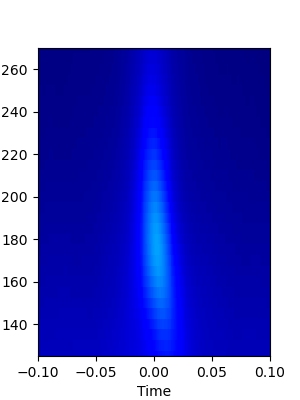

In [97]:
# Sanity check - plot mean ripple wavelet
event_times = ripple_epochs.to_dataframe()['peak_time'].values
buffer_sec = (0.1, 0.1)
wv_use = wv_sig_swr

# Code here to remove events that start or finish outside of the recording time.

sxx_list2 = []
ntime_bins = int(np.sum(buffer_sec)*wv_use.sampling_rate)
for t_event in event_times:
    start_time = t_event - buffer_sec[0]
    stop_time = t_event + buffer_sec[1]
    wvlet_temp = wv_use.time_slice(t_start=start_time, t_stop=stop_time)

    # Add/remove one frame at end if array size doesn't match expected number of time bins
    if len(wvlet_temp.time) != ntime_bins:
        if len(wvlet_temp.time) == (ntime_bins + 1):
            stop_time -= 0.5/wv_use.sampling_rate
        elif len(wvlet_temp.time) == (ntime_bins - 1):
            stop_time += 0.5/wv_use.sampling_rate
        else:
            print('Error - time bins off by more than 1')
        wvlet_temp = wv_use.time_slice(t_start=start_time, t_stop=stop_time)
    sxx_list2.append(wvlet_temp.traces)

sxx2_mean = np.stack(sxx_list2, axis=2).mean(axis=2)
wv_swr_mean = Spectrogram(sxx2_mean, wv_use.freqs, sampling_rate=signal.sampling_rate, 
                            t_start=-buffer_sec[0])
_, ax = plt.subplots(figsize=(3, 4))

plot_spectrogram2(wv_swr_mean, time=[-buffer_sec[0], buffer_sec[1]], freq=[125, 270], ax=ax)

## CS analyses

In [98]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath, zero_timestamps=True)
ttl_df[ttl_df['channel_states'] == 2].head(5)

,channel_states,timestamps,datetimes,event_name
616,2,3550347,2022-08-04 12:25:54.344900000,
1245,2,5430969,2022-08-04 12:26:57.032300000,
1966,2,7586021,2022-08-04 12:28:08.867366667,
2727,2,9862870,2022-08-04 12:29:24.762333333,
3427,2,11956605,2022-08-04 12:30:34.553500000,


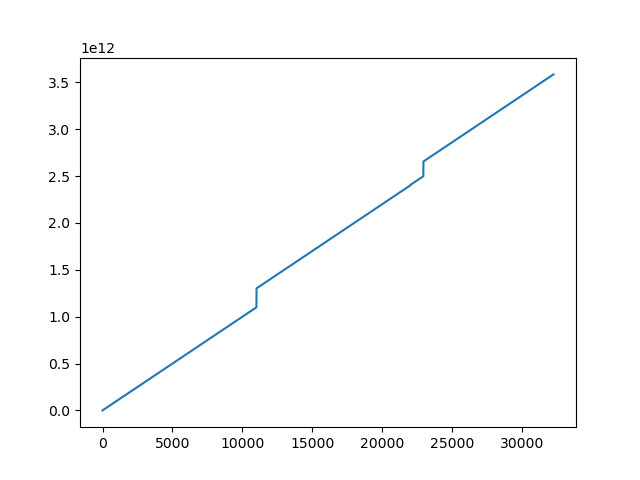

In [99]:
# Sanity check - plot should be monotonically increasing if all timestamps were read in properly!
im_ts = ttl_df[ttl_df['channel_states'].abs() == 1]
ttt = (im_ts['datetimes'] - im_ts['datetimes'].iloc[0]).values
_, ax = plt.subplots()
ax.plot(ttt)

In [100]:
import tracefc.io.traceio as traceio
cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", 
                                                      event_type="CS+", return_df=True)
print(f'{cs_starts.shape[0]} CS events detected')
cs_starts.head(6)

15 CS events detected


,Time (s),Event,Timestamp
5,61.717939,CS1_start,2022-08-04 12:25:54.919410900
7,124.405071,CS2_start,2022-08-04 12:26:57.606542782
9,196.239824,CS3_start,2022-08-04 12:28:09.441295580
11,272.134283,CS4_start,2022-08-04 12:29:25.335755066
13,341.925044,CS5_start,2022-08-04 12:30:35.126516298
15,409.700099,CS6_start,2022-08-04 12:31:42.901571230


In [104]:
# Need to figure out a way to filter out/collect only the proper time stamps assuming things have a 
# +/- 1 second start difference in the CSV vs OpenEphys

# Make below a function 'calc_cs_lag' in traceio module.
start_diff = (ttl_df[ttl_df['channel_states'] == 2]['datetimes'].head(15) - cs_starts['Timestamp'].values)
start_diff_mean = pd.Timedelta(np.abs(start_diff.dt.total_seconds().mean()), unit='seconds')
print(start_diff_mean)
print(start_diff)

ttl_lag_use = pd.Timedelta(0.7, unit='seconds')

0 days 00:00:00.571839517
616     -1 days +23:59:59.425489100
1245    -1 days +23:59:59.425757218
1966    -1 days +23:59:59.426071087
2727    -1 days +23:59:59.426578267
3427    -1 days +23:59:59.426983702
4108    -1 days +23:59:59.427395437
4869    -1 days +23:59:59.427804957
5539    -1 days +23:59:59.428163295
6270    -1 days +23:59:59.428753323
6899    -1 days +23:59:59.429109588
7691    -1 days +23:59:59.429354452
8320    -1 days +23:59:59.429718062
8980    -1 days +23:59:59.430106684
9609    -1 days +23:59:59.430386484
10228   -1 days +23:59:59.430735586
Name: datetimes, dtype: timedelta64[ns]


Timedelta('0 days 00:00:00.700000')

In [105]:
def recording_events_to_combined_time(event_df_use: pd.DataFrame, sync_df_use: pd.DataFrame, time_out='eeg_time',
                                      sync_ts_key: str='Datetime', event_ts_key: str='datetimes'):

    # Calc and check that each cs occurs in the same recording.
    nrec_start = [sync_df['Recording'][np.max(np.nonzero(start > sync_df_use[sync_ts_key]))] for start in event_df_use[event_ts_key]]
    nrec_stop = [sync_df['Recording'][np.min(np.nonzero(start < sync_df_use[sync_ts_key]))] for start in event_df_use[event_ts_key]]
    
    # Loop through each recording and calculate CS time in combined dat/eeg file
    if nrec_start == nrec_stop:
        event_time_comb = []
        for nrec, event_time in zip(nrec_start, event_df_use[event_ts_key]):
            # Get correct start time of recording in the desired output time (eeg/dat) and timestamp
            rec_start_time = sync_df_use[(sync_df_use['Recording'] == nrec) & (sync_df_use['Condition'] == 'start')][time_out].values[0]
            rec_start_timestamp = sync_df_use[(sync_df_use['Recording'] == nrec) & (sync_df_use['Condition'] == 'start')][sync_ts_key].iloc[0]
            event_dt = (event_time - rec_start_timestamp).total_seconds()
            event_time_comb.append(event_dt + rec_start_time)
    
        event_time_comb = np.array(event_time_comb)
    
    else:
        print(f'Recording start and end numbers do not all match. starts = {nrec_start}, ends = {nrec_stop}.')
        event_time_comb = np.nan

    return event_time_comb
        

In [106]:
def trace_ttl_to_openephys(trace_cs_df: pd.DataFrame, oe_ttls_df: pd.DataFrame, ttl_lag=pd.Timedelta(0.33, unit='seconds'), 
                           trace_ts_key='Timestamp', oe_ts_key='datetimes'):
    """Finds TTLs in OpenEphys that correspond to CS timestamps recorded from python in a CSV file, assuming a consistent
    time lag from CS start to delivery in OpenEphys
    ttl_lag: amount of time OE LAGS the csv in tracefc csv. Enter a negative number if lag is positive for some reason."""

    cs_bool = np.zeros(len(oe_ttls_df[oe_ts_key]), dtype=bool)
    event_ind = []
    for ide, event in enumerate(trace_cs_df[trace_ts_key]):
        cs_bool = cs_bool | ((oe_ttls_df[oe_ts_key] > (event - ttl_lag)) & (oe_ttls_df[oe_ts_key] < (event + ttl_lag)))
        if sum(((oe_ttls_df[oe_ts_key] > (event - ttl_lag)) & (oe_ttls_df[oe_ts_key] < (event + ttl_lag)))) == 1:
            event_ind.append(ide)

    trace_cs_sync_df = oe_ttls_df[cs_bool]
    
    # Calculate start time difference mean and std to make sure you are getting a consistent lag
    # print(f'cs_bool sum = {cs_bool.sum()}, event_ind={event_ind}')  # For debugging
    start_diff = (trace_cs_sync_df[oe_ts_key] - trace_cs_df[trace_ts_key].iloc[event_ind].values).dt.total_seconds()
    
    print(f'start time lag: mean = {start_diff.mean()}, std = {start_diff.std()}')
    return trace_cs_sync_df 
    # Need to add a sanity check to make sure you aren't grabbing crazy different times! - maybe spit out average lag time between files?

In [107]:
from neuropy.io.openephysio import create_sync_df
sync_df = create_sync_df(sess.basepath)
sync_df

start time = 2022-08-04 12:23:56.581623-04:00
start time = 2022-08-04 12:45:27.837675-04:00
start time = 2022-08-04 13:07:02.327536-04:00


,Recording,Datetime,Condition,nframe_dat,dat_time,nframe_eeg,eeg_time
0,0,2022-08-04 12:23:56.581623-04:00,start,0,0.000000,0,0.0000
1,0,2022-08-04 12:44:28.999723-04:00,stop,36972543,1232.418100,1540522,1232.4176
2,1,2022-08-04 12:45:27.837675-04:00,start,36972544,1232.418133,1540523,1232.4184
3,1,2022-08-04 13:06:38.655775-04:00,stop,75097087,2503.236233,3129045,2503.2360
4,2,2022-08-04 13:07:02.327536-04:00,start,75097088,2503.236267,3129046,2503.2368
5,2,2022-08-04 13:25:13.783502667-04:00,stop,107840767,3594.692233,4493365,3594.6920


In [108]:
# Grab CS times corresponding to OE timestamps
cs_oe_start_df = trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_start_df['datetimes'] = cs_oe_start_df['datetimes'].dt.tz_localize("America/Detroit")

cs_oe_end_df = trace_ttl_to_openephys(cs_ends, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use)
cs_oe_end_df['datetimes'] = cs_oe_end_df['datetimes'].dt.tz_localize("America/Detroit")

start time lag: mean = -0.5718395172000001, std = 0.0017393610604866253
start time lag: mean = -0.5721254076666666, std = 0.0017675796841863762


interactive(children=(FloatSlider(value=20.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(…

<Axes: xlabel='Time', ylabel='Frequency'>

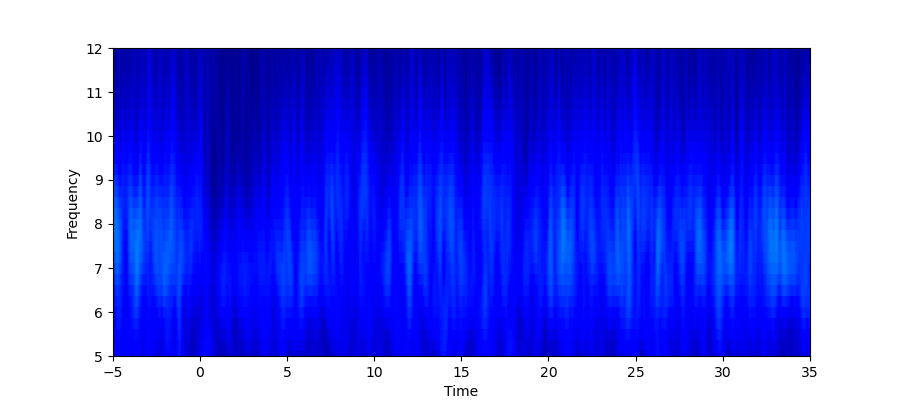

In [111]:
# Plot mean wavelet spectrogram at CS+ onset
event_times = cs_oe_start_df['timestamps']/30000
buffer_sec = (5, 35)
wv_use = wv_sig

# Code here to remove events that start or finish outside of the recording time.

sxx_list2 = []
ntime_bins = int(np.sum(buffer_sec)*wv_use.sampling_rate)
for t_event in event_times:
    start_time = t_event - buffer_sec[0]
    stop_time = t_event + buffer_sec[1]
    wvlet_temp = wv_use.time_slice(t_start=start_time, t_stop=stop_time)

    # Add/remove one frame at end if array size doesn't match expected number of time bins
    if len(wvlet_temp.time) != ntime_bins:
        if len(wvlet_temp.time) == (ntime_bins + 1):
            stop_time -= 0.5/wv_use.sampling_rate
        elif len(wvlet_temp.time) == (ntime_bins - 1):
            stop_time += 0.5/wv_use.sampling_rate
        else:
            print('Error - time bins off by more than 1')
        wvlet_temp = wv_use.time_slice(t_start=start_time, t_stop=stop_time)
    sxx_list2.append(wvlet_temp.traces)

sxx2_mean = np.stack(sxx_list2, axis=2).mean(axis=2)
wv_mean = Spectrogram(sxx2_mean, wv_use.freqs, sampling_rate=signal.sampling_rate, 
                            t_start=-buffer_sec[0])
_, ax = plt.subplots(figsize=(9, 4))

plot_spectrogram2(wv_mean, time=[-buffer_sec[0], buffer_sec[1]], freq=[5, 12], ax=ax)
ax.set_xlabel('Time from CS+ (sec)')

In [112]:
csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", 
                                                      event_type="CS-", return_df=True)
print(f'{cs_starts.shape[0]} CS events detected')
cs_starts.head(6)

15 CS events detected


,Time (s),Event,Timestamp
5,61.717939,CS1_start,2022-08-04 12:25:54.919410900
7,124.405071,CS2_start,2022-08-04 12:26:57.606542782
9,196.239824,CS3_start,2022-08-04 12:28:09.441295580
11,272.134283,CS4_start,2022-08-04 12:29:25.335755066
13,341.925044,CS5_start,2022-08-04 12:30:35.126516298
15,409.700099,CS6_start,2022-08-04 12:31:42.901571230


In [114]:
# Grab CS times corresponding to OE timestamps
csn_oe_start_df = trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=ttl_lag_use*2)
csn_oe_start_df['datetimes'] = csn_oe_start_df['datetimes'].dt.tz_localize("America/Detroit")

start time lag: mean = -0.8315851157500003, std = 0.0012104381031523726


interactive(children=(FloatSlider(value=20.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(…

Text(0.5, 0, 'Time from CS- (sec)')

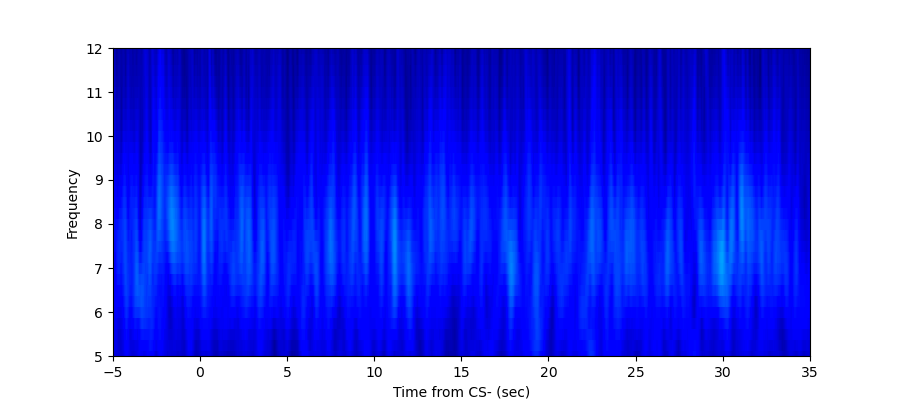

In [115]:
# Plot mean wavelet at CS- onset
event_times = csn_oe_start_df['timestamps']/30000
buffer_sec = (5, 35)
wv_use = wv_sig

# Code here to remove events that start or finish outside of the recording time.

sxx_list2 = []
ntime_bins = int(np.sum(buffer_sec)*wv_use.sampling_rate)
for t_event in event_times:
    start_time = t_event - buffer_sec[0]
    stop_time = t_event + buffer_sec[1]
    wvlet_temp = wv_use.time_slice(t_start=start_time, t_stop=stop_time)

    # Add/remove one frame at end if array size doesn't match expected number of time bins
    if len(wvlet_temp.time) != ntime_bins:
        if len(wvlet_temp.time) == (ntime_bins + 1):
            stop_time -= 0.5/wv_use.sampling_rate
        elif len(wvlet_temp.time) == (ntime_bins - 1):
            stop_time += 0.5/wv_use.sampling_rate
        else:
            print('Error - time bins off by more than 1')
        wvlet_temp = wv_use.time_slice(t_start=start_time, t_stop=stop_time)
    sxx_list2.append(wvlet_temp.traces)

sxx2_mean = np.stack(sxx_list2, axis=2).mean(axis=2)
wv_mean = Spectrogram(sxx2_mean, wv_use.freqs, sampling_rate=signal.sampling_rate, 
                            t_start=-buffer_sec[0])
_, ax = plt.subplots(figsize=(9, 4))

plot_spectrogram2(wv_mean, time=[-buffer_sec[0], buffer_sec[1]], freq=[5, 12], ax=ax)
ax.set_xlabel('Time from CS- (sec)')

## Fourier Analysis - not great looking

In [50]:
from neuropy.utils.signal_process import FourierSg

channel_use = theta_channel
signal = sess.eegfile.get_signal()
fsg = FourierSg(signal.time_slice(channel_id=channel_use), freqs=np.arange(4, 13, 0.25), window=0.1,
               overlap=0.05, multitaper=True)
# fsg_sm = FourierSg(signal.time_slice(channel_id=channel_use), sigma=2)
# fsg_mt = FourierSg(signal.time_slice(channel_id=channel_use), multitaper=True)
# fsg_mt_sm = FourierSg(signal.time_slice(channel_id=channel_use), multitaper=True, sigma=2)

interactive(children=(FloatSlider(value=20.0, description='Clim :', max=30.0, min=0.1), IntRangeSlider(value=(…

<Axes: xlabel='Time', ylabel='Frequency'>

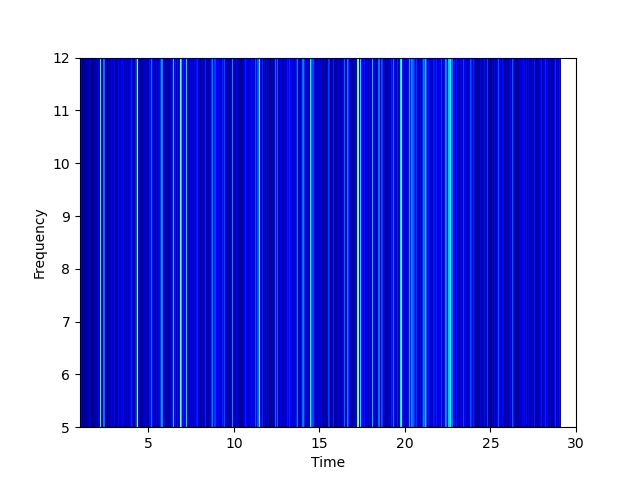

In [51]:
plot_spectrogram2(fsg, time=[1, 30], freq=[5, 12])

In [ ]:
fsg.freq_slice(5, 20).t_start

In [ ]:
fsg_peri_cs[0].shape

In [ ]:
np.concatenate(fsg_peri_cs).shape

In [ ]:
buffer_sec = (5, 35)
for fsg_use, fst_type in zip([fsg, fsg_sm, fsg
fsg_peri_cs = []
for start_time in cs_oe_start_df['timestamps'].values/30000:
    ftemp = fsg_use.freq_slice(5, 12).time_slice(start_time - buffer_sec[0], start_time + buffer_sec[1])
    fsg_peri_cs.append(ftemp.traces)

_, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(fsg.freq_slice(5, 12).time_slice(1, 5000).traces, ax=ax, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels([ int(freq) for freq in fsg.freq_slice(5, 12).freqs])

In [ ]:
_, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(fsg.freq_slice(5, 12).time_slice(1, 5000).traces, ax=ax, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels([ int(freq) for freq in fsg.freq_slice(5, 12).freqs])

## Save notebook to working directory

In [116]:
from neuropy.utils.manipulate_files import save_notebook
save_notebook(sess.basepath, save_prepend=f"{sess_name}_")

/data/GitHub/TraceFC/Notebooks/Spectral_Analysis.ipynb saved to /data2/Trace_FC/Recording_Rats/Han/2022_08_04_recall1/Han_recall1_Spectral_Analysis.ipynb
